# Forecasting Total Factor Productivity for USA/CAN/MEX
---

## Total Factor Productivity

In this notebook we are trying to forecast the total factor productivity of Usa, Canada and Mexico, by using time series analysis. We will implement one of the most used models that is ARIMA, where the data presents no seasonality, but may have some trend.

In [126]:
# necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('fivethirtyeight')

In [3]:
# reading csv
tfp = pd.read_csv('TFP.csv')

In [4]:
# checking structure of tfp dataframe
tfp.head()

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179


In [5]:
# there are no missing values in the dataframe
tfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   isocode  186 non-null    object 
 1   year     186 non-null    int64  
 2   rtfpna   186 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.5+ KB


As we only have three countries I will divide this dataframe in three for simplicity.

In [6]:
usa = tfp[tfp.isocode == 'USA']
can = tfp[tfp.isocode == 'CAN']
mex = tfp[tfp.isocode == 'MEX']

Checking trends in the time series for each country. We see that USA has a tendency to increase TFP over years. Canada has a slight increase up until approximately 1975, when it stabilized until 2000, and then started decreasing again. Mexico has a very large increase until 1970 and after 1980 it started to largely decrease.

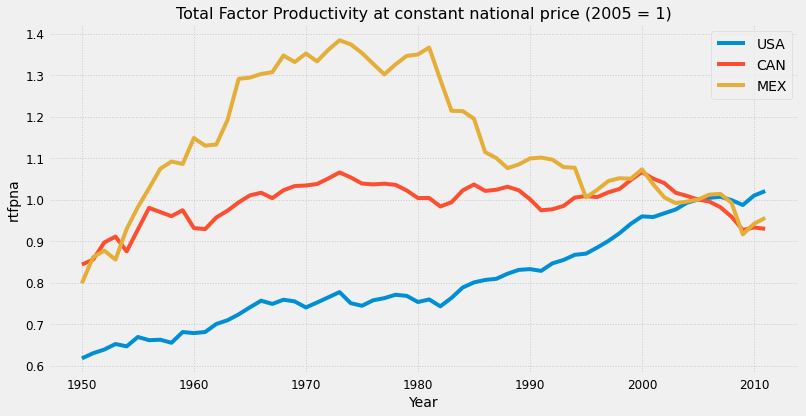

In [7]:
# making plot to see the behavior of the time
plt.figure(figsize=(12,6))
plt.plot(usa.year, usa.rtfpna, label='USA')
plt.plot(can.year, can.rtfpna, label='CAN')
plt.plot(mex.year, mex.rtfpna, label='MEX')
plt.xlabel('Year', fontsize=14)
plt.ylabel('rtfpna', fontsize=14)
plt.title('Total Factor Productivity at constant national price (2005 = 1)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle=':')
plt.legend(loc=1, fontsize=14)
plt.show()

In [8]:
print('Increase in TFP from 1950 to 2011')
print('USA: %.2f%%' % ((usa.iloc[-1, -1] - usa.iloc[0, -1])/usa.iloc[0, -1]*100))
print('CAN: %.2f%%' % ((can.iloc[-1, -1] - can.iloc[0, -1])/can.iloc[0, -1]*100))
print('MEX: %.2f%%' % ((mex.iloc[-1, -1] - mex.iloc[0, -1])/mex.iloc[0, -1]*100))

Increase in TFP from 1950 to 2011
USA: 65.34%
CAN: 10.21%
MEX: 19.75%


We cannot compare the TFP between countries with this data since we only have the TFP at constant national price.

### Forecasting TFP for the next 10 years

By looking at the graph we see that the time series are non stationary, but to make the model more robust let's check with Dickey-Fuller statistical model if the time series have unit roots (to help us understand if they are stationary or not).

In [9]:
index = ['USA', 'CAN', 'MEX']
x = {'ADF Statistic': [], 'p-value': [], 'CV1%': [], 'CV5%': [], 'CV10%': []}

# USA
result = adfuller(usa.rtfpna.values)
x['ADF Statistic'].append(result[0])
x['p-value'].append(result[1])
x['CV1%'].append(result[4]['1%'])
x['CV5%'].append(result[4]['5%'])
x['CV10%'].append(result[4]['10%'])

# CAN
result = adfuller(can.rtfpna.values)
x['ADF Statistic'].append(result[0])
x['p-value'].append(result[1])
x['CV1%'].append(result[4]['1%'])
x['CV5%'].append(result[4]['5%'])
x['CV10%'].append(result[4]['10%'])

# MEX
result = adfuller(mex.rtfpna.values)
x['ADF Statistic'].append(result[0])
x['p-value'].append(result[1])
x['CV1%'].append(result[4]['1%'])
x['CV5%'].append(result[4]['5%'])
x['CV10%'].append(result[4]['10%'])

result_df = pd.DataFrame(x, index=index)
result_df

,ADF Statistic,p-value,CV1%,CV5%,CV10%
USA,0.223647,0.973557,-3.542413,-2.910236,-2.592745
CAN,-3.027753,0.032383,-3.544369,-2.911073,-2.593190
MEX,-1.940444,0.313281,-3.562879,-2.918973,-2.597393


As we can see from the p-values of the statistical model that the USA time serie has a very clearly trend (non-stationary), MEX has also a non-stationary time serie. For CAN we see that the p-value is less than 0.05 so a better model would be ARMA instead of ARIMA.

Directly from the graphs we see no seasonality in the values, and also, there is no reason to believe that there is.

Because the time series are non stationary and has no seasonality we will apply the ARIMA model (except Canada) to try to forecast the TFP for the next 10 years.

For the ARIMA model we have to find the best values for the parameters 'p', 'q', and 'd'. To do that without having to directly look at the ACF and PACF graphs, we are going to use auto_arima. It automatically finds the best values for 'p', 'q', and 'd' by fitting models within ranges of defined start_p, max_p, start_q, max_q ranges.

In [160]:
# IMPORTANT FUNCTIONS TO CLEAN THE CODE

# divide data set into train and test
# the first 85% of the data will be used to train the model and the next 15% to test it
def split_data(df, frac=0.85):
    train = df.iloc[:int(df.shape[0]*frac)]
    test = df.iloc[int(df.shape[0]*frac):]
    
    return train, test


# get order and diagnostic of the model ARIMA
def get_order_ARIMA(train, d=None):
    model_autoARIMA = auto_arima(train['rtfpna'].values, start_p=0, start_q=0,
                            test='adf',       # use adftest to find optimal 'd'
                            max_p=6, max_q=6, # maximum p and q
                            m=1,              # frequency of series
                            d=d,           # let model determine 'd'
                            seasonal=False,   # No Seasonality
                            start_P=0, 
                            D=0, 
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
    # plot diagnostics
    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    plt.show()
    
    # return the order of the model
    return model_autoARIMA.order


# fit ARIMA model
def model_ARIMA(df, order):
    model = ARIMA(df['rtfpna'].values, order=order)
    fit = model.fit()
    return fit


# plot predictions
def plot_prediction(df, fc, conf, test, pred_test=False):
    plt.figure(figsize=(12,7))
    plt.plot(df['year'], df['rtfpna'], label='Training')
    if pred_test:
        plt.plot(test['year'], test['rtfpna'], label='Actual Values')
        
    # getting year of predictions
    x_fc = np.arange(df['year'].max() + 1, df['year'].max() + len(fc) + 1)
    
    # plotting prediction with 95% confidential interval
    plt.plot(x_fc, fc, label='Predicted Values')
    plt.fill_between(x_fc, conf[:, 0], conf[:, 1], color='k', alpha=0.1)
    plt.title(f'Predicting TFP values for {df.isocode.iloc[0]}')
    plt.xlabel('Year')
    plt.ylabel('rtfpna')
    plt.legend(loc='upper left', fontsize=14)
    plt.show()
    
    
# measure performance in test set
def perfomance(test, fc):
    mse = mean_squared_error(test['rtfpna'].values, fc)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(test['rtfpna'].values, fc)
    print('MAE: '+str(mae))
    rmse = np.sqrt(mean_squared_error(test['rtfpna'].values, fc))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(fc - test['rtfpna'].values)/np.abs(test['rtfpna'].values))
    print('MAPE: '+str(mape))

### USA

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=-265.971, BIC=-262.147, Time=0.129 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=-277.595, BIC=-271.859, Time=0.138 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=-294.215, BIC=-288.479, Time=0.308 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=-267.956, BIC=-266.044, Time=0.067 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=-279.223, BIC=-271.575, Time=0.079 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=-283.039, BIC=-273.479, Time=0.083 seconds
Fit ARIMA(4,2,0)x(0,0,0,0) [intercept=True]; AIC=-283.457, BIC=-271.985, Time=0.259 seconds
Fit ARIMA(5,2,0)x(0,0,0,0) [intercept=True]; AIC=-282.993, BIC=-269.609, Time=0.441 seconds
Fit ARIMA(4,2,1)x(0,0,0,0) [intercept=True]; AIC=-285.060, BIC

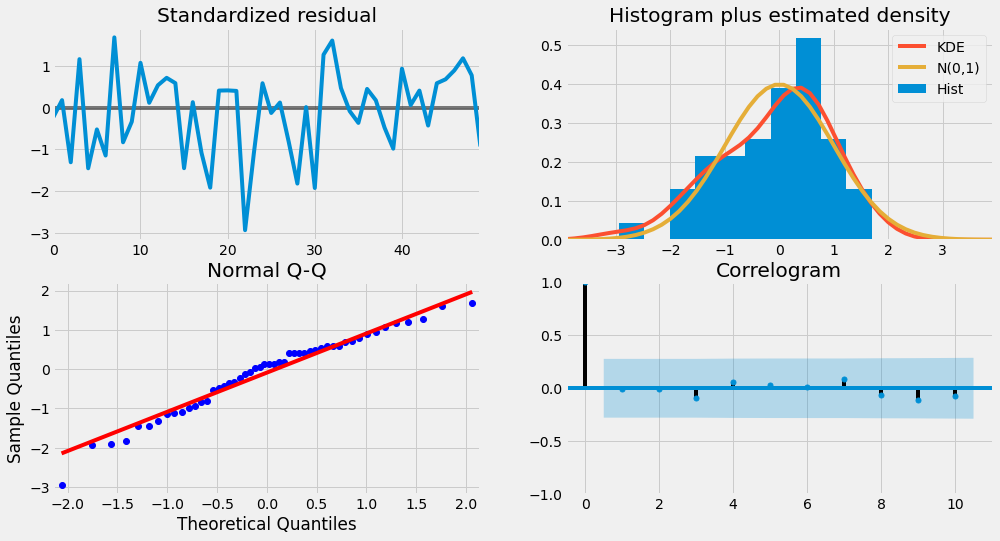

The order of the ARIMA model is: (0, 2, 1)


In [95]:
train_usa, test_usa = split_data(usa)
order_usa = get_order_ARIMA(train_usa)
print('The order of the ARIMA model is: ' + str(order_usa))
arima_usa_test = model_ARIMA(train, order_usa)

The residual errors seems to be fluctuating around the zero mean. The Q-Q plot and the histogram shows that the distribution is approximately normal. The Correlogram (ACF plot) shows that the residuals are not autocorrelated.

So ARIMA(0, 2, 1) is probably a good model to be used.

Now, let's forecast the test set to see the performance of the model.

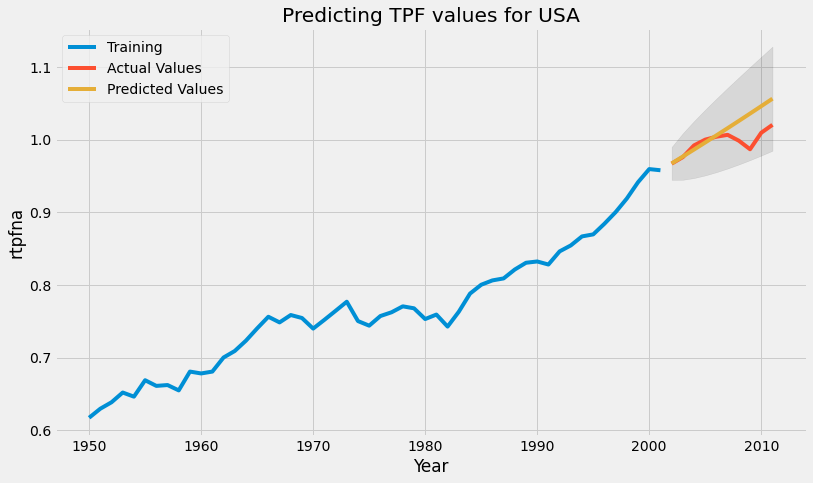

MSE: 0.0005931350971853216
MAE: 0.017088182240390593
RMSE: 0.024354365054037472
MAPE: 0.017053106654948535


In [96]:
# forecasting the test set to check the perfomance of the model
fc_usa_test, _, conf_usa_test = arima_usa_test.forecast(test_usa.shape[0], alpha=0.05)  # 95% confidence

#plot the prediction
plot_prediction(train_usa, fc_usa_test, conf_usa_test, test_usa, pred_test=True)
perfomance(test_usa, fc_usa_test)

We see that the model performs really well in the test set. MAPE show that the model has 98.3% accuracy in predicting the test set.

Now, let's fit the model for the entire dataset and predict the next ten years

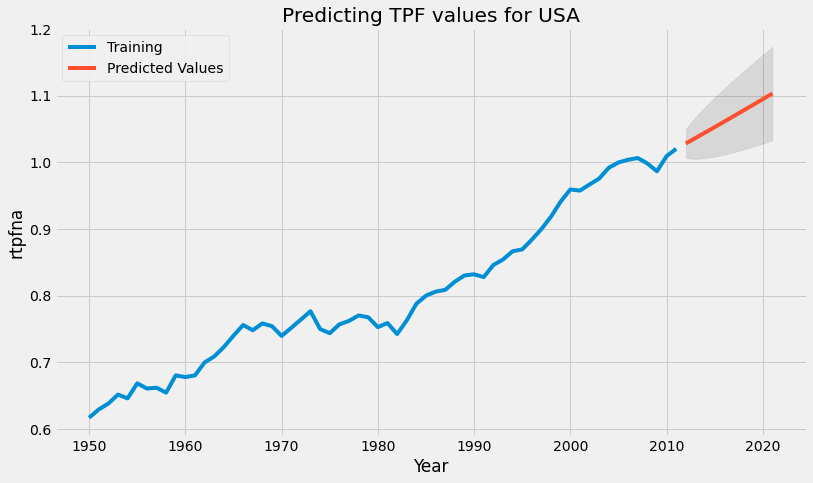

In [97]:
# fitting model in the entire dataset
arima_usa_final = model_ARIMA(usa, order_usa)
# forecasting the test set to check the perfomance of the model
fc_usa_final, _, conf_usa_final = arima_usa_final.forecast(10, alpha=0.05)  # 95% confidence

#plot the prediction
plot_prediction(usa, fc_usa_final, conf_usa_final, test_usa)

In [159]:
# getting percentage of increase
print('ARIMA model is predicting a growth of %.1f%% in the TFP values on 2021 comparing with 2011 for USA.' % 
      ((fc_usa_final[-1]-usa.rtfpna.values[-1])/usa.rtfpna.values[-1]*100))

ARIMA model is predicting a growth of 8.1% in the TFP values on 2021 comparing with 2011 for USA.


### Canada

For this case we will use d=0 (ARMA model), because in the statistical test we saw that there is not a clear trend.

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-157.468, BIC=-153.566, Time=0.069 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-252.906, BIC=-247.052, Time=0.260 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-208.409, BIC=-202.555, Time=0.095 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=149.248, BIC=151.199, Time=0.024 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=-253.121, BIC=-245.316, Time=0.350 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=-254.863, BIC=-245.107, Time=0.355 seconds
Fit ARIMA(4,0,0)x(0,0,0,0) [intercept=True]; AIC=-257.820, BIC=-246.112, Time=0.376 seconds
Fit ARIMA(5,0,0)x(0,0,0,0) [intercept=True]; AIC=-253.149, BIC=-239.490, Time=0.488 seconds
Fit ARIMA(4,0,1)x(0,0,0,0) [intercept=True]; AIC=-254.692, BIC=-241.033, Time=0.420 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=-255.700, BIC=-243.992, Time=0.422 seconds
Fit ARIMA(5,0,1)x(0,0,0,0) [intercept=

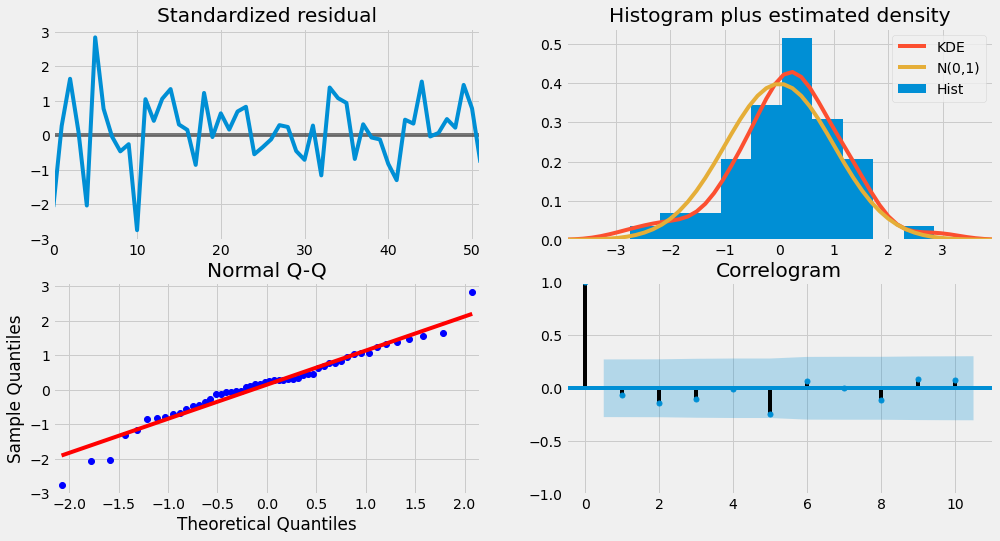

The order of the ARIMA model is: (4, 0, 0)


In [125]:
train_can, test_can = split_data(can, frac=0.85)
order_can = get_order_ARIMA(train_can, d=0)
print('The order of the ARIMA model is: ' + str(order_can))
arima_can_test = model_ARIMA(train_can, order_can)

We see from the diagnostic plot that the model ARIMA(4,0,0) is probably a good model to try to predict the TFP value for Canada.

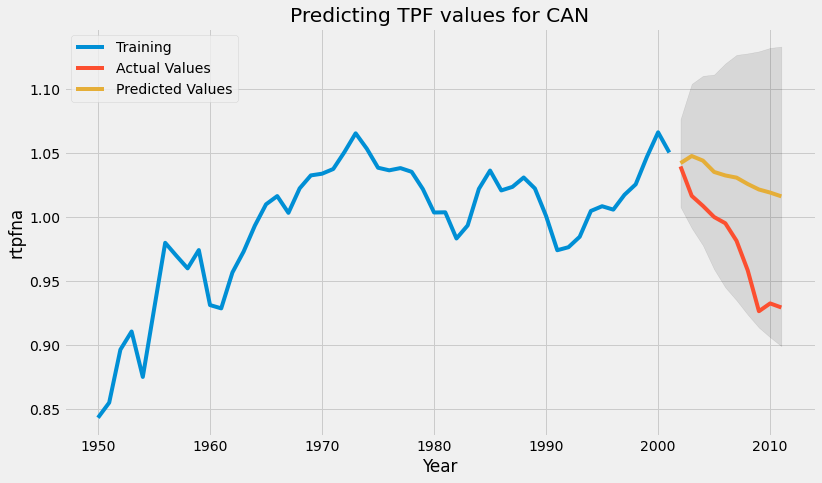

MSE: 0.003585831501410322
MAE: 0.05264843301615287
RMSE: 0.05988181277658787
MAPE: 0.05500014421810303


In [123]:
# forecasting the test set to check the perfomance of the model
fc_can_test, _, conf_can_test = arima_can_test.forecast(test_can.shape[0], alpha=0.05)  # 95% confidence

#plot the prediction
plot_prediction(train_can, fc_can_test, conf_can_test, test_can, pred_test=True)
perfomance(test_can, fc_can_test)

The model presents 94.5% of accuracy according to MAPE, but the confidence interval is very large which makes the prediction not vey trustable.

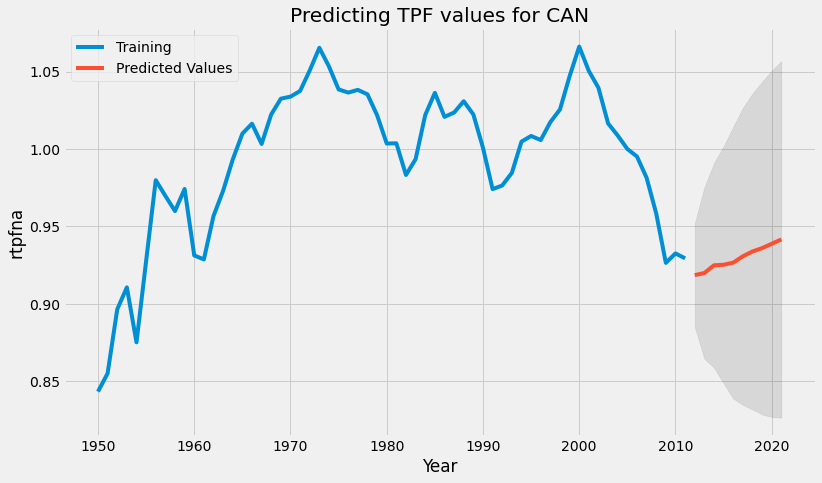

In [130]:
# fitting model in the entire dataset
arima_can_final = model_ARIMA(can, order_can)
# forecasting the test set to check the perfomance of the model
fc_can_final, _, conf_can_final = arima_can_final.forecast(10, alpha=0.05)  # 95% confidence

#plot the prediction
plot_prediction(can, fc_can_final, conf_can_final, test_can)

We see that the confidence interval is very large. This model does not seem to be a good model for predicting TFP for canada. One way to try to make a better prediction would be to use neural networks but it is more computationally expensive, and for it to be worth it we would need to have much more data.

In [135]:
# getting percentage of increase
print('ARIMA model is predicting a growth of %.1f%% in the TPF values on 2021 comparing with 2011 for Canada.' % 
      ((fc_can_final[-1]-can.rtfpna.values[-1])/can.rtfpna.values[-1]*100))

ARIMA model is predicting a growth of 1.3% in the TPF values on 2021 comparing with 2011 for Canada.


### Mexico

For this case we will also use ARIMA model, as used for the USA case.

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=-166.738, BIC=-162.914, Time=0.037 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=-172.482, BIC=-166.746, Time=0.062 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=-189.084, BIC=-183.348, Time=0.370 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=-168.637, BIC=-166.725, Time=0.068 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=-178.069, BIC=-170.421, Time=0.141 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=-179.716, BIC=-170.156, Time=0.179 seconds
Fit ARIMA(4,2,0)x(0,0,0,0) [intercept=True]; AIC=-177.880, BIC=-166.408, Time=0.459 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=-184.265, BIC=-172.793, Time=0.414 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=-186.306, BIC

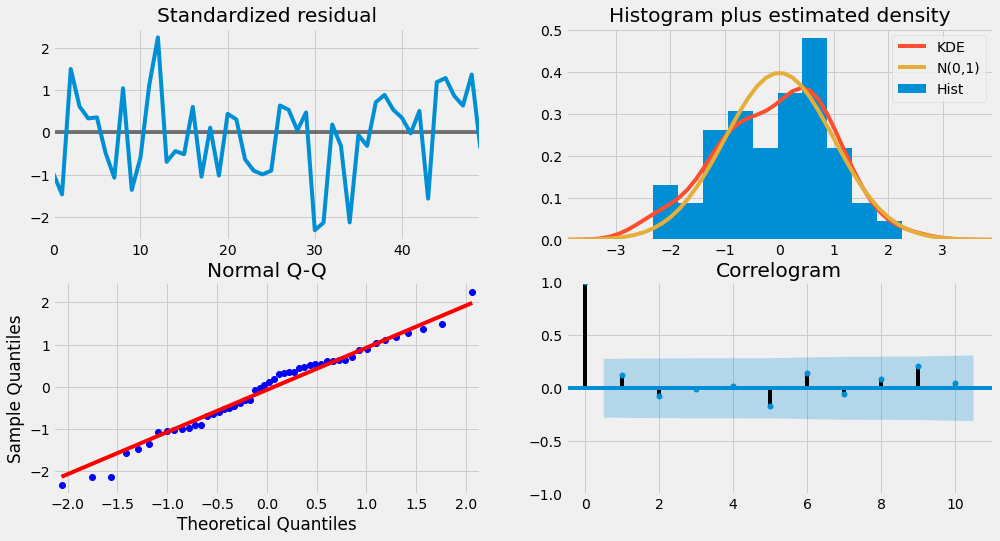

The order of the ARIMA model is: (0, 2, 1)


/home/artur/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [132]:
train_mex, test_mex = split_data(mex, frac=0.85)
order_mex = get_order_ARIMA(train_mex)
print('The order of the ARIMA model is: ' + str(order_mex))
arima_mex_test = model_ARIMA(train_mex, order_mex)

The ARIMA(0, 2, 1) may be a good model, according to the diagnostic plot.

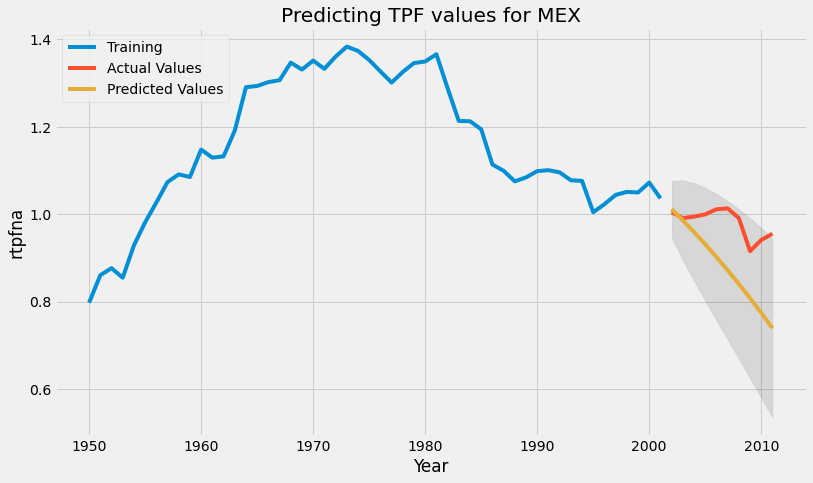

MSE: 0.014670168886250962
MAE: 0.10075008818099943
RMSE: 0.12112047261405053
MAPE: 0.10360182455982596


In [133]:
# forecasting the test set to check the perfomance of the model
fc_mex_test, _, conf_mex_test = arima_mex_test.forecast(test_mex.shape[0], alpha=0.05)  # 95% confidence

#plot the prediction
plot_prediction(train_mex, fc_mex_test, conf_mex_test, test_mex, pred_test=True)
perfomance(test_mex, fc_mex_test)

The model presents 89.6% accuracy, but the confidential interval is very large. We are probably underestimating the real prediction, by looking at the above graph.

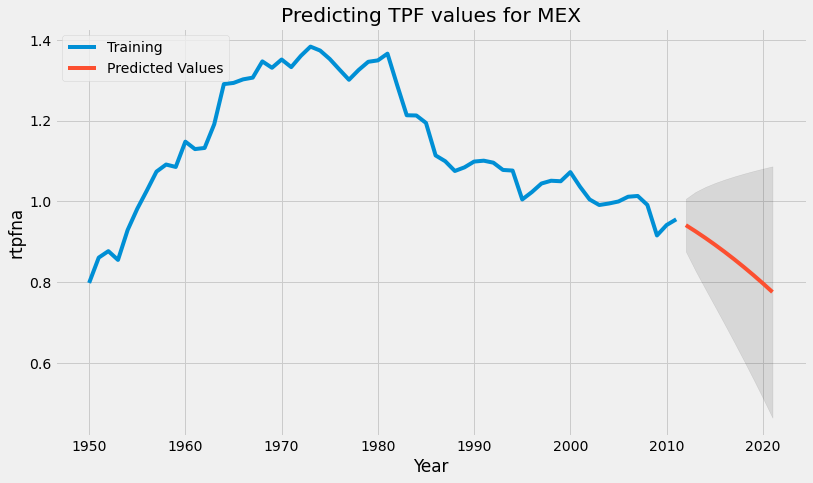

In [134]:
# fitting model in the entire dataset
arima_mex_final = model_ARIMA(mex, order_mex)
# forecasting the test set to check the perfomance of the model
fc_mex_final, _, conf_mex_final = arima_mex_final.forecast(10, alpha=0.05)  # 95% confidence

#plot the prediction
plot_prediction(mex, fc_mex_final, conf_mex_final, test_mex)

In [158]:
# getting percentage of increase
print('ARIMA model is predicting a degrowth of %.1f%% in the TFP values on 2021 comparing with 2011 for Mexico.' % 
      (abs((fc_mex_final[-1]-mex.rtfpna.values[-1])/mex.rtfpna.values[-1]*100)))

ARIMA model is predicting a degrowth of 18.8% in the TFP values on 2021 comparing with 2011 for Mexico.


Although the model is predicting a large degrowth, this degrowth is probably an underestimation of the real value.

The ARIMA model for the USA is a very good model to forecast TFP because the data has a clear trend and does not have sudden changes, seasonality and a lot of noise.

For Canada and Mexico there is not a clear trend, or at least it changes over time without seasonality. There are probably external features that influences the behavior of the TFP series.

### External features

emp: Number of persons engaged (in millions). The more people engaged probably the productivity will increase.

hc:  Provides an index of human capital per person, which is based on average years of schooling and the return to education. The higher this index probably the higher the tfp, since we will have more people capable of producing work.

rgdpna: Because it is the real GDP at constant 2005 national prices (in million 2005 USD). The GDP has a positive correlation with the productivity factor of a country.
